In [1]:
import torch
import captum
import torch.nn as nn

from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

In [355]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [356]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [358]:
import numpy as np

from torchvision import transforms

import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F



In [359]:
class PneumoniaModelBase(nn.Module):

    # this is for loading the batch of train image and outputting its loss, accuracy
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy

        return {'train_loss': loss, 'train_acc':acc}

    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies

        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}

    # this is for loading the batch of val/test image and outputting its loss, accuracy,
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds

        return {'val_loss': loss.detach(), 'val_acc':acc.detach(),
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory

    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))

    # this is for using on the test set, it outputs the average loss and acc,
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

In [360]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier

    def forward(self, xb):
        return self.network(xb)

In [361]:
# this is for loading the model from a previously saved one
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath , map_location=torch.device('cpu'))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/PneumoniaResnet_1.pth')

In [362]:
# load an image from the test folder
def load_image(img_path):
    image = Image.open(img_path)
    image = transform(image)
    return image


In [364]:
# get the paht for the test folder 
test_dir = 'C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/data/chest_xray/test'


In [363]:
# define the transformation for the image
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [365]:
from sklearn.utils import shuffle
# load the test dataset
test_dataset = ImageFolder(test_dir, transform=transform)
# Shuffle the test dataset
test_dataset = shuffle(test_dataset)

In [187]:
# Evaluate the model on a single immage 
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    # return dataset.classes[preds[0].item()]
    return preds[0].item()
    

In [319]:
# Pick five different images from the test dataset with label 0, and return the index


def get_image_idx(test_dataset, n, lable):
    count = 0
    index = []
    for i in range(len(test_dataset)):
        if  count < n and test_dataset[i][1] == lable:
            index.append(i)
            count += 1
        if count == n:
            break
    return index


In [348]:
n_img = 10
idx0 = get_image_idx(test_dataset, n_img, 0)
idx1 = get_image_idx(test_dataset, n_img, 1)

In [350]:
# Initialize the attribution algorithm with the model
ig = IntegratedGradients(model)


Predicted: 1


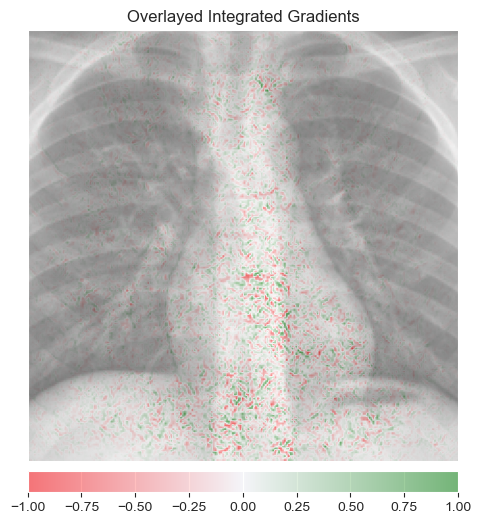

Predicted: 1


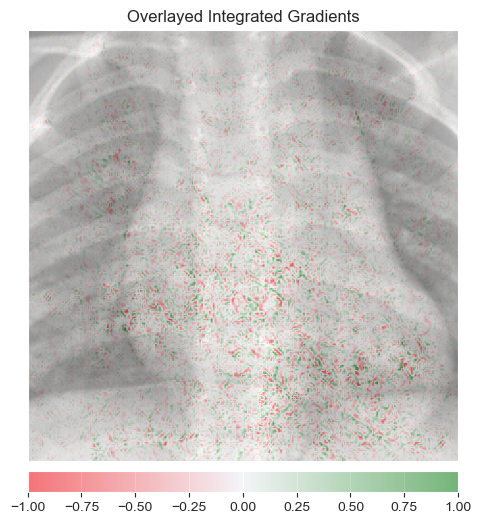

Predicted: 1


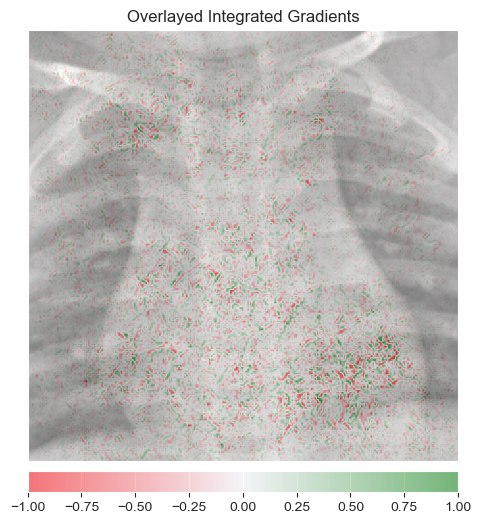

Predicted: 1


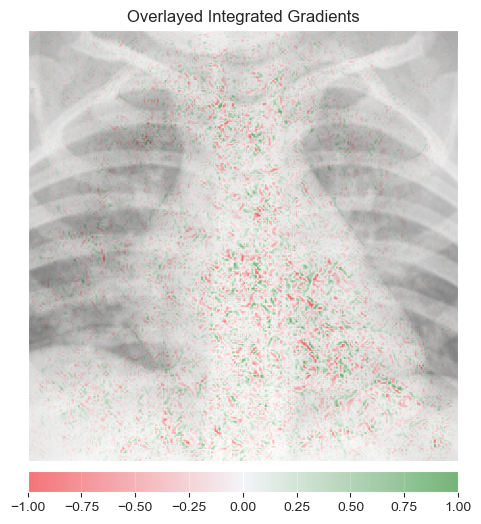

Predicted: 0


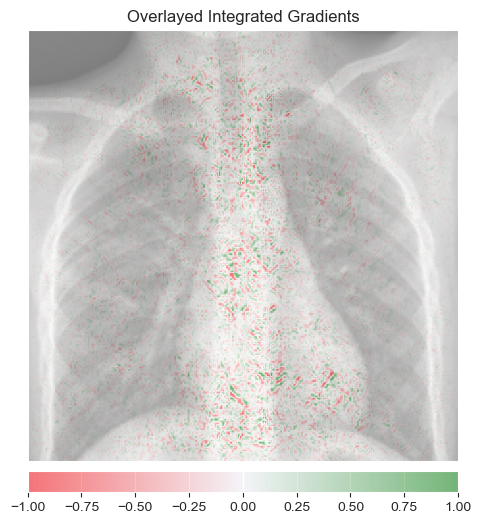

Predicted: 0


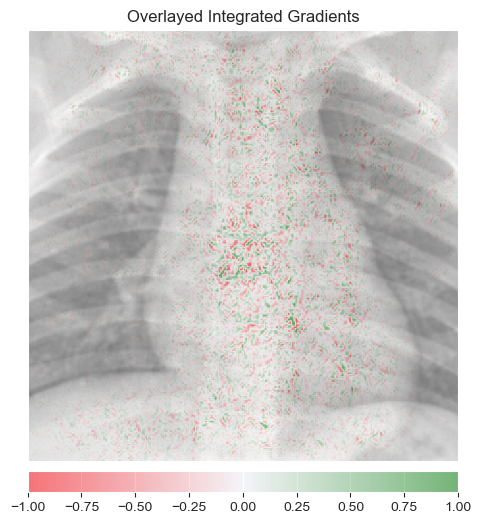

Predicted: 0


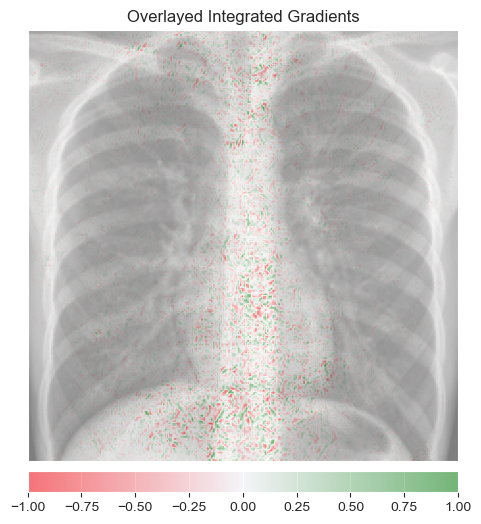

Predicted: 0


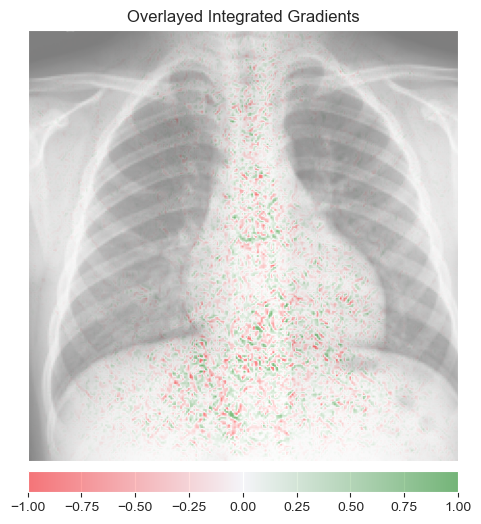

Predicted: 1


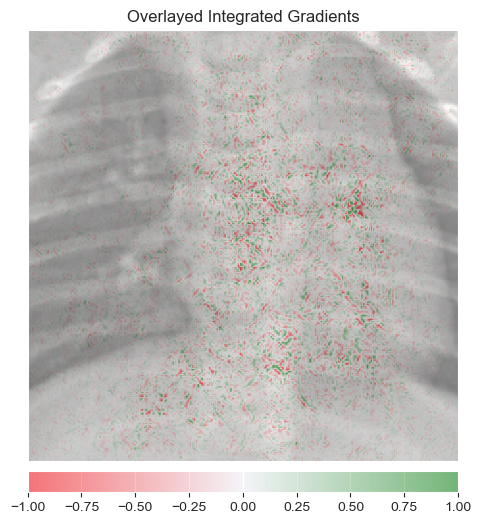

Predicted: 0


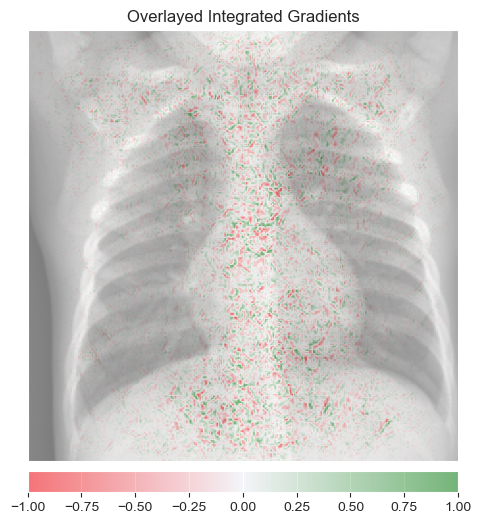

In [351]:
# load the image with label 0
for i in idx0:
    img = test_dataset[i][0]
    pred = predict_image(img, model)
    attr = ig.attribute(img.unsqueeze(0), 
                    target=pred,
                    n_steps=200)
    
    print('Predicted:', pred)
    _ = viz.visualize_image_attr(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             sign='all',
                             show_colorbar=True,
                             title='Overlayed Integrated Gradients')

Predicted: 1


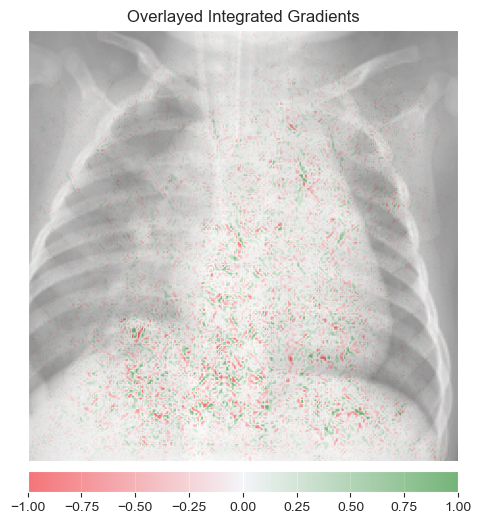

Predicted: 1


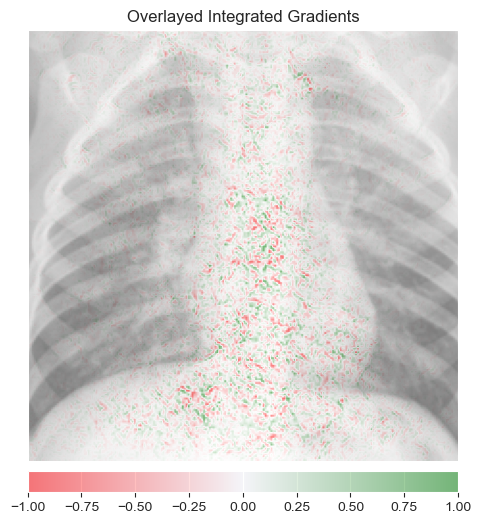

Predicted: 1


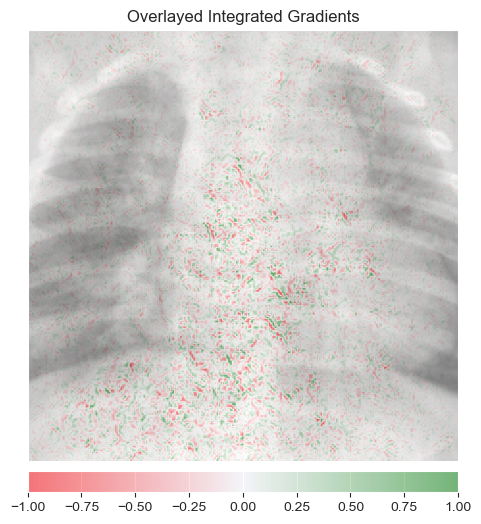

Predicted: 1


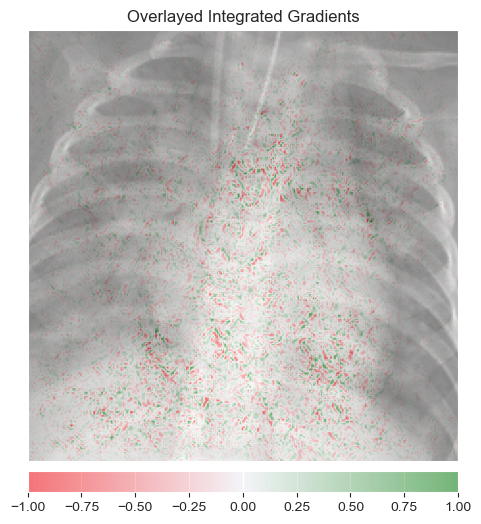

Predicted: 1


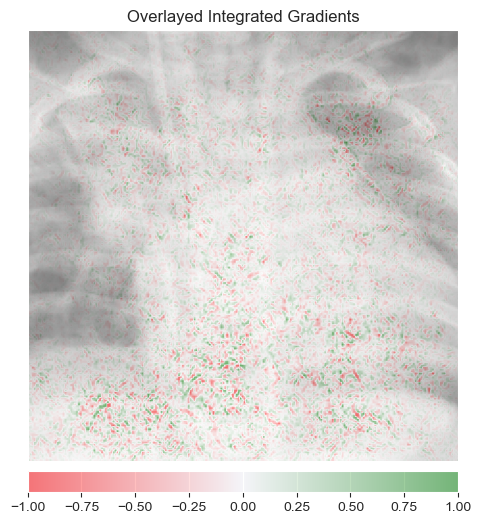

Predicted: 1


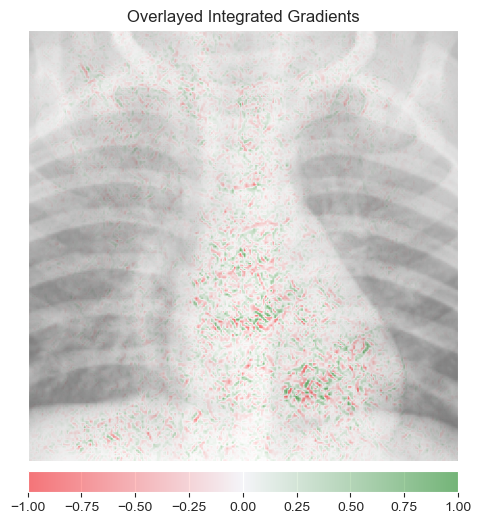

Predicted: 1


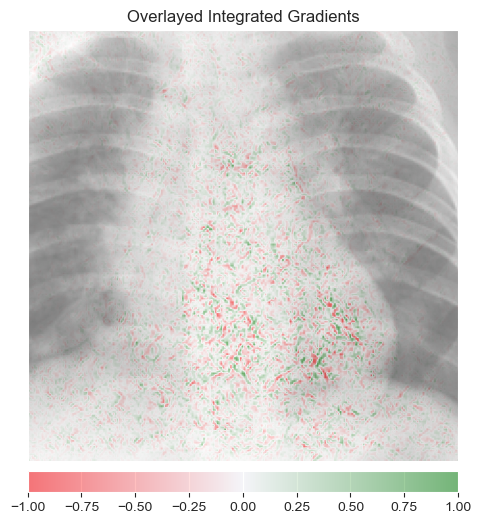

Predicted: 1


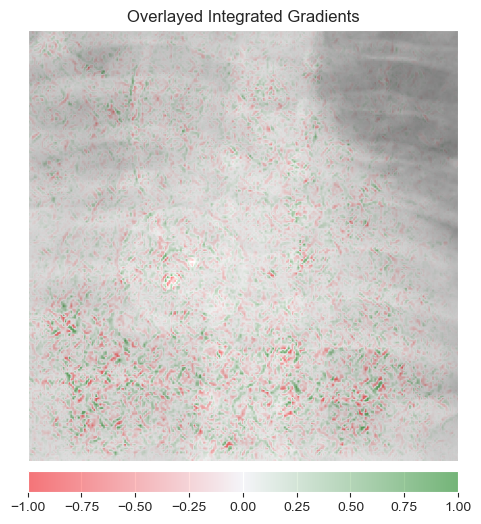

Predicted: 1


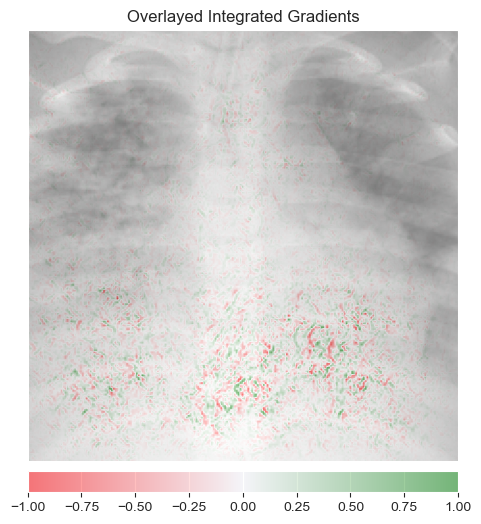

Predicted: 1


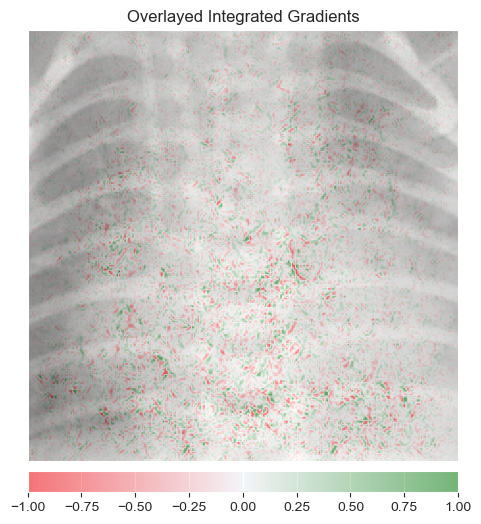

In [352]:
# load the image with label 0
for i in idx1:
    img = test_dataset[i][0]
    pred = predict_image(img, model)
    attr = ig.attribute(img.unsqueeze(0), 
                    target=pred,
                    n_steps=200)
    
    print('Predicted:', pred)
    _ = viz.visualize_image_attr(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             sign='all',
                             show_colorbar=True,
                             title='Overlayed Integrated Gradients')

Test for a single image

In [342]:
# predict the image label with the model and store the prediction
pred = predict_image(img, model)
pred

1

In [270]:
# Initialize the attribution algorithm with the model
ig = IntegratedGradients(model)


In [271]:
# Ask the algorithm to attribute our output target to
# the input image
attr = ig.attribute(img.unsqueeze(0), 
                    target=pred,
                    n_steps=200)

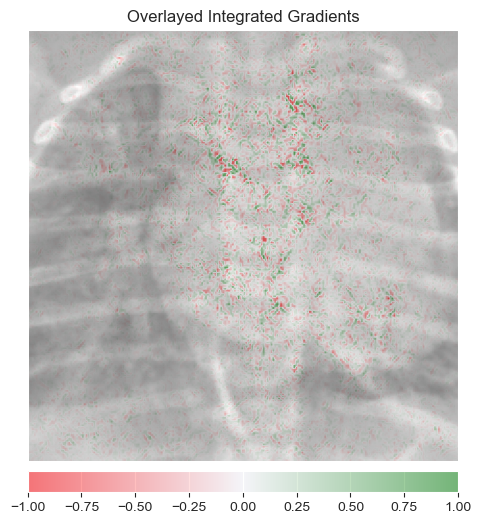

In [272]:
# Visualize the image and the attribution 
_ = viz.visualize_image_attr(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             sign='all',
                             show_colorbar=True,
                             title='Overlayed Integrated Gradients')